Inspired by https://www.johndcook.com/blog/2008/10/21/what-happens-when-you-add-a-new-teller/

In [292]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as tt

In [293]:
service_avg = 10.3
arrivals_avg = 10
visitors = 50

all_wt = []
def mean_waiting_time(tellers):
    means = []
    for i in range(1000):
        queue_times = np.zeros(tellers)
        waiting_times = []
        for j in range(visitors):
            arrival = np.random.poisson(arrivals_avg)

            smaller_queue = np.argmin(queue_times)

            for i, q in enumerate(queue_times):
                queue_times[i] = max(0, queue_times[i] - arrival)
            waiting_times.append(queue_times[smaller_queue])
            all_wt.append(queue_times[smaller_queue])

            service = np.random.exponential(service_avg)
            queue_times[smaller_queue] += service

        means.append(np.mean(waiting_times))
    return np.mean(means)

print("mean_waiting_time with 1 teller", mean_waiting_time(1), "min")
print("mean_waiting_time with 2 tellers", mean_waiting_time(2), "min")

mean_waiting_time with 1 teller 36.31711829451329 min
mean_waiting_time with 2 tellers 0.9515962056813041 min


First lets simulate the same but using pymc3

In [294]:
visitors = 50

with pm.Model():
    arrivals = pm.Poisson("arrivals", arrivals_avg, shape=visitors)
    services = pm.Exponential("services", 1 / service_avg, shape=visitors)
    
    queue_time = tt.zeros(1)
    waiting_times = tt.zeros((visitors, 1))
    for i in range(visitors):
        queue_time -= arrivals[i]
        queue_time = tt.switch(queue_time < tt.zeros(1), tt.zeros(1), queue_time)
        waiting_times = tt.set_subtensor(waiting_times[i], queue_time)
        queue_time += services[i]
    pm.Deterministic("waiting_time", tt.mean(waiting_times))

    trace = pm.sample(1000)
    
np.mean(trace["waiting_time"])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [arrivals]
>NUTS: [services]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 373.77draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


35.852939448382564

Now let's try to go on the oposite direction, we know how much people are spending waiting on the line in average, so let's try to discover what's the avg arrival time and avg service time.

First we collect all waiting times

In [295]:
all_wt = []
mean_waiting_time(1)
np.mean(all_wt)

37.673666396694706

Then we plot it to see to what distribution it looks like. Apparently it's exponential

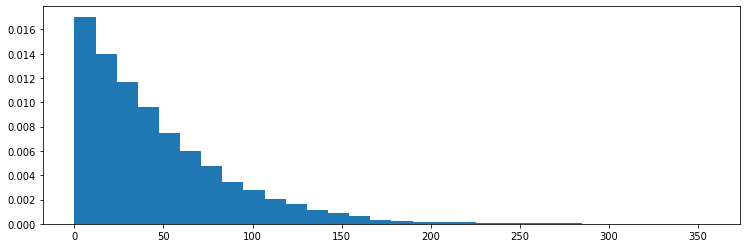

In [298]:
plt.figure(figsize=(12.5,4))
plt.hist([x for x in all_wt if x > 0], histtype="stepfilled", density=True, bins=30)
plt.show()

Now let's try to reverse-engineer the arrivals and service avg

In [307]:
visitors = 50

with pm.Model() as model:
    arrivals_avg = pm.Uniform("arrivals_avg", 5, 15)
    service_avg = pm.Uniform("service_avg", 5, 15)
    
    arrivals = pm.Poisson("arrivals", arrivals_avg, shape=visitors)
    services = pm.Exponential("services", 1 / service_avg, shape=visitors)
    
    queue_time = tt.zeros(1)
    waiting_times = tt.zeros((visitors, 1))
    for i in range(visitors):
        queue_time -= arrivals[i]
        queue_time = tt.switch(queue_time < tt.zeros(1), tt.zeros(1), queue_time)
        waiting_times = tt.set_subtensor(waiting_times[i], queue_time)
        queue_time += services[i]
    waiting_time = pm.Exponential("waiting_time", 1 / tt.mean(waiting_times), observed=all_wt)

    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)
    
print(np.mean(trace["arrivals_avg"]))
print(np.mean(trace["service_avg"]))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [services]
>Metropolis: [arrivals]
>Metropolis: [service_avg]
>Metropolis: [arrivals_avg]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 430.08draws/s]


10.0
10.0


No handles with labels found to put in legend.


arrivals_avg 10.0


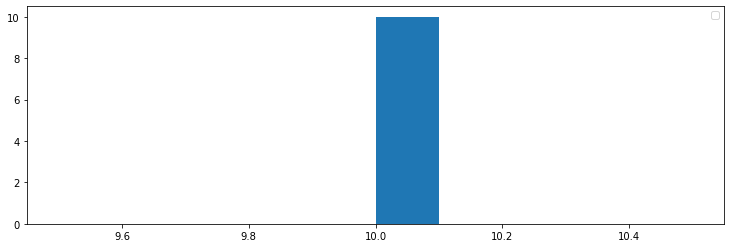

No handles with labels found to put in legend.


service_avg 10.0


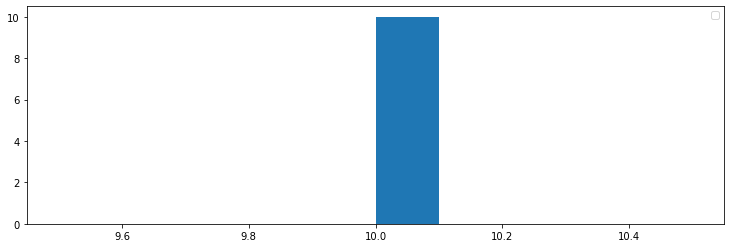

In [308]:
print("arrivals_avg", np.mean(trace["arrivals_avg"][1000:]))
plt.figure(figsize=(12.5,4))
plt.hist(trace["arrivals_avg"], histtype="stepfilled", density=True)
plt.legend()
plt.show()

print("service_avg", np.mean(trace["service_avg"][1000:]))
plt.figure(figsize=(12.5,4))
plt.hist(trace["service_avg"], histtype="stepfilled", density=True)
plt.legend()
plt.show()

Good enough, I'd say